# Ice shelf masks

This is to unobscure the following masks
- OBCS: maskInC/W/S
- CTRL: maskCtrlC/W/S
- shelfice: maskSHI (only at C points)
- shelfice: maskCtrlU (only at C points)

In [2]:
import os
import sys
import numpy as np
import xarray as xr
import xgcm
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
dir_with_masks_and_grid = '/workspace/results/pig/masks'

ds = open_mdsdataset(data_dir=dir_with_masks_and_grid,
                     geometry='sphericalpolar',
                     ignore_unknown_vars=True)

/workspace/xmitgcm/xmitgcm/mds_store.py:815: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/masks. Using default version.
  "in %s. Using default version." % data_dir)
/workspace/xmitgcm/xmitgcm/utils.py:429: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/workspace/xmitgcm/xmitgcm/mds_store.py:269: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


## Add maskSHI 

Mimic computation of `maskSHI` as in `shelfice_init_fixed.F`

`maskSHI` is:
- Surface layer: 1 where ice shelf touches water
- Other layers: 1 on wet points 

`rSurfC` is necessary to show where iceshelf is 

`hFacC` necessary to find the few points where the ice shelf touches ground below first depth level but has no wet points in that column

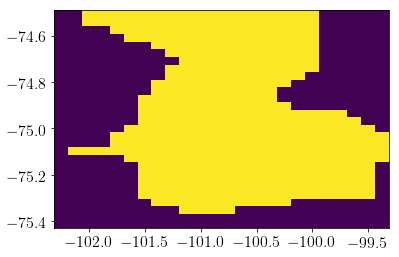

In [4]:
# I know these are the same size because I made mskCtrlU after maskSHI
msk1 = np.where(ds.rSurfC < ds.Zp1[0],1,0)
msk2 = np.where(ds.hFacC != 0,1,0)
msk3 = msk2.sum(axis=0)
msk4 = np.where(msk3 >= 1,1,0)

msk5 = msk4 & msk1  
msk5 = msk5.reshape((1,len(ds.YC),len(ds.XC)))

mskshi = np.concatenate((msk5,msk2[1:,:,:]),axis=0)

# Assign a new variable to dataset ...
ds['maskSHI'] = xr.DataArray(mskshi,
                             coords=ds.hFacC.coords)

plt.figure()
plt.pcolormesh(ds.XC,ds.YC,msk1)
plt.figure()
plt.pcolormesh(ds.XC,ds.YC,msk4)
plt.figure()
plt.pcolormesh(ds.XC,ds.YC,ds.maskSHI.isel(Z=0))
plt.show()

## maskSHI vs maskCtrlU

First, surface layer

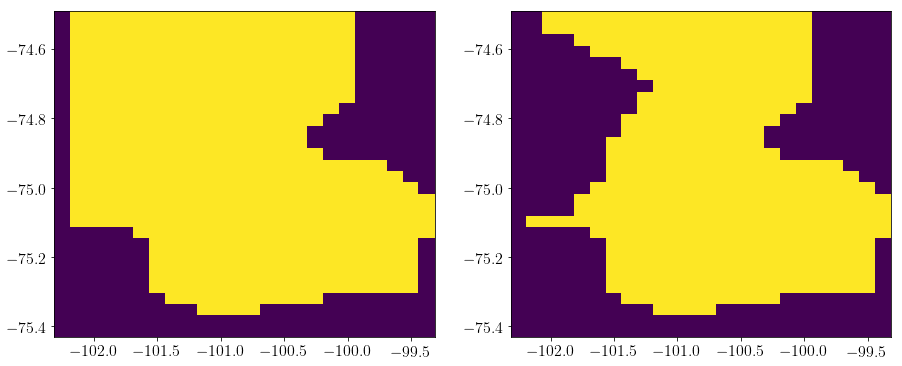

In [5]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.pcolormesh(ds.XC,ds.YC,ds.maskCtrlU.isel(Z=0))
plt.subplot(1,2,2)
plt.pcolormesh(ds.XC,ds.YC,ds.maskSHI.isel(Z=0))
plt.show()

### On the surface layer:
- `maskCtrlU` = `maskInC` = all wet non-obcs points 
- `maskSHI` shows all wet points interfacing with the iceshelf

So `maskCtrlU` would be useful for grabbing 2D variables like `depth` and `etaN` while `maskSHI` is useful for `gammaT`

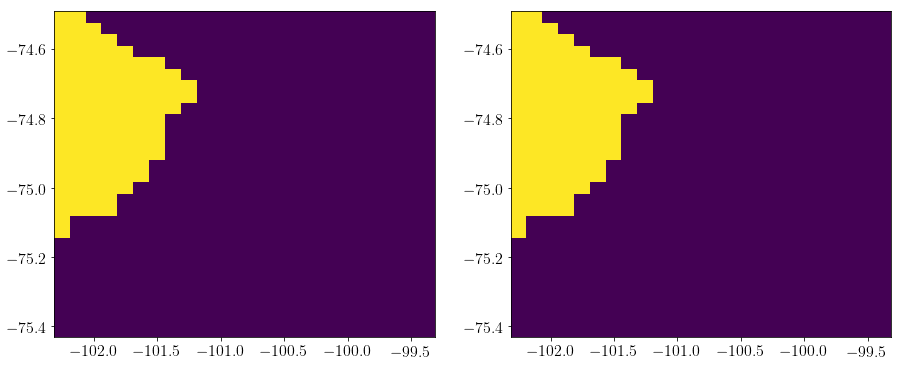

In [6]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.pcolormesh(ds.XC,ds.YC,ds.maskCtrlU.isel(Z=1))
plt.subplot(1,2,2)
plt.pcolormesh(ds.XC,ds.YC,ds.maskSHI.isel(Z=1))
plt.show()

### below the surface:
Both are equal to `maskC`, show the points where `hFacC` != 0 

## Surface: maskC & maskCtrlC

See `ctrl_init_wet.F`, these are equivalent

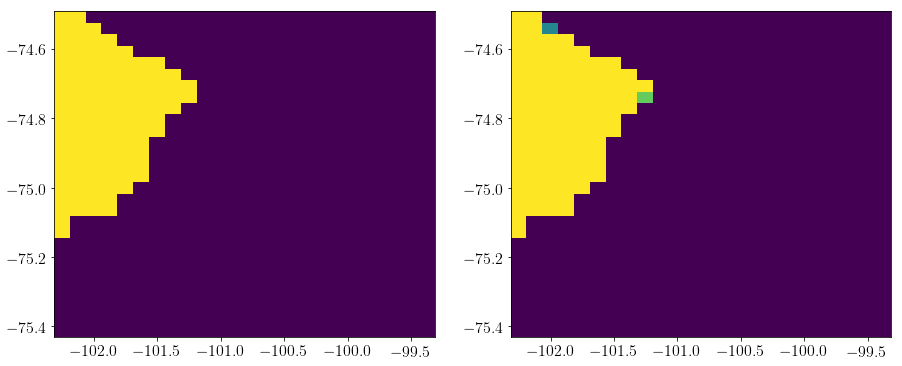

In [7]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.pcolormesh(ds.XC,ds.YC,ds.maskCtrlC.isel(Z=0))
plt.subplot(1,2,2)
plt.pcolormesh(ds.XC,ds.YC,ds.hFacC.isel(Z=0))
plt.show()

## Compare some totals with ctrl_init_wet.F

In [25]:
print('sum surface wet C = ',ds.maskCtrlC.isel(Z=0).values.sum())
print('sum surface wet W = ',ds.maskCtrlW.isel(Z=0).values.sum())
print('sum surface wet S = ',ds.maskCtrlS.isel(Z=0).values.sum())
print('sum surface wet U = ',ds.maskCtrlU.isel(Z=0).values.sum())
print('sum total surface = ',ds.maskCtrlC.isel(Z=0).values.sum()+
                              ds.maskCtrlW.isel(Z=0).values.sum()+
                              ds.maskCtrlS.isel(Z=0).values.sum()+
                              ds.maskCtrlU.isel(Z=0).values.sum())
print('sum 3D maskC = ',ds.maskCtrlC.values.sum())
print('sum 3D maskW = ',ds.maskCtrlW.values.sum())
print('sum 3D maskS = ',ds.maskCtrlS.values.sum())


sum surface wet C =  109.0
sum surface wet W =  88.0
sum surface wet S =  100.0
sum surface wet U =  490.0
sum total surface =  787.0
sum 3D maskC =  8151.0
sum 3D maskW =  7024.0
sum 3D maskS =  7218.0


750
